# Example usage - Command line

Example with 4D-Lung sample which uses a RTSTRUCT segmentation

In [2]:
!readii ../tests/4D-Lung ../tests/output/notebook/ --roi_names Tumor_c.\* --pyradiomics_setting ../src/readii/data/default_pyradiomics.yaml --update true

Starting readii pipeline...
Finding med-imagetools outputs...
Getting segmentation type...
Matching CT to segmentations...
Starting radiomic feature extraction...
Processing  113_HM10395
labels: {'Tumor_c40': 0}
Calculating radiomic features for segmentation: Tumor_c40
Pipeline complete.


Example with NSCLC Radiogenomics sample which uses a DICOM-SEG segmentation

In [3]:
!readii ../tests/NSCLC_Radiogenomics ../tests/output/notebook/ --pyradiomics_setting ../src/readii/data/default_pyradiomics.yaml --update true

Starting readii pipeline...
Finding med-imagetools outputs...
Getting segmentation type...
No suitable segmentation type found. YAREA can only use RTSTRUCTs and DICOM-SEG segmentations.
Feature extraction not complete.


# Example usage - Functions

Here we will demonstrate how to use the helper functions in readii to load and preprocess a CT image and a corresponding segmentation in DICOM SEG format.

## Imports

In [1]:
from imgtools.io import read_dicom_series
from readii.loaders import loadSegmentation
from readii.image_processing import flattenImage, alignImages, displayImageSlice, displayCTSegOverlay

## Load a CT and segmentation

We'll first load in a CT image and segmentation to process.

In [2]:
ctImage = read_dicom_series("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/3.000000-THORAX_1.0_B45f-95741")

In [3]:
segImages = loadSegmentation("../tests/NSCLC_Radiogenomics/R01-001/09-06-1990-NA-CT_CHEST_ABD_PELVIS_WITH_CON-98785/1000.000000-3D_Slicer_segmentation_result-67652/1-1.dcm",
                            modality = 'SEG')
print(segImages)

{'Heart': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x7fb10022e690> >}


We can see here that the segmentation file contained one region of interest labelled 'Heart'.

## Pre-process the segmentation

We can then process the segmentation image so it's ready for analysis with the CT. We process each region of interest (ROI) individually, so we extract the 'Heart' segmentation first.

In [4]:
roiImage = segImages['Heart']

Now, let's ensure the dimensions match between the CT and heart segmentation.

In [5]:
print("CT dimensions: ", ctImage.GetSize())
print("Segmentation dimensions: ", roiImage.GetSize())

CT dimensions:  (512, 512, 304)
Segmentation dimensions:  (512, 512, 304, 1)


We can see that the segmentation has an extra dimension with a length of 1. Let's remove this.

In [6]:
flattenedROIImage = flattenImage(roiImage)
print("Segmentation dimensions: ", flattenedROIImage.GetSize())

Segmentation dimensions:  (512, 512, 304)


Next is aligning the segmentation to the CT.

In [7]:
alignedROIImage = alignImages(ctImage, flattenedROIImage)

## Plot CT image

We can now plot the CT image.

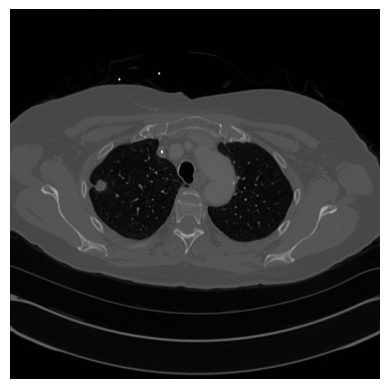

In [8]:
displayImageSlice(ctImage, 240)

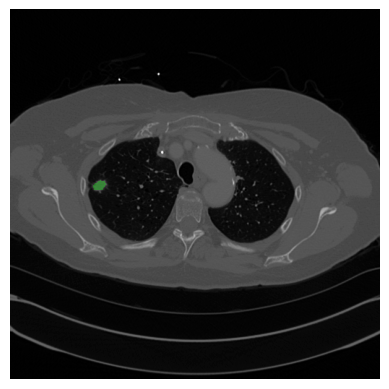

In [9]:
displayCTSegOverlay(ctImage, alignedROIImage)

## Extract Radiomic Features

In [12]:
from readii.feature_extraction import singleRadiomicFeatureExtraction

pyradiomicsParamFilePath = "../src/readii/data/default_pyradiomics.yaml"
radiomicFeatures = singleRadiomicFeatureExtraction(ctImage, roiImage, pyradiomicsParamFilePath)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [13]:
import pandas as pd
pd.DataFrame.from_dict(radiomicFeatures, orient="index").transpose()

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,gradient_gldm_LargeDependenceLowGrayLevelEmphasis,gradient_gldm_LowGrayLevelEmphasis,gradient_gldm_SmallDependenceEmphasis,gradient_gldm_SmallDependenceHighGrayLevelEmphasis,gradient_gldm_SmallDependenceLowGrayLevelEmphasis,gradient_ngtdm_Busyness,gradient_ngtdm_Coarseness,gradient_ngtdm_Complexity,gradient_ngtdm_Contrast,gradient_ngtdm_Strength
0,v3.0.1a3,1.26.4,2.3.1,1.5.0,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'Square': {}, ...",d9fb72bb8f6703c6661ad6e4b1be90b837c5d6cd,3D,"(0.693359375, 0.693359375, 1.0)",...,15.63611676150815,0.14251302405997665,0.29702038662248775,42.893223270813046,0.008426069042557105,1.373689639013812,0.0054614251087468455,478.02313430435777,0.33308911261443386,1.0574349195401984


## Negative Control Creation

In [14]:
from readii.negative_controls import *

### Shuffle whole image

In [15]:
shuffledImage = shuffleImage(ctImage)
originalPixels = sitk.GetArrayFromImage(ctImage)
shuffledPixels = sitk.GetArrayFromImage(shuffledImage)

In [ ]:
displayCTSegOverlay(shuffledImage, alignedROIImage, alpha=0.4)

In [ ]:
from readii.image_processing import getROICenterCoords

getROICenterCoords(alignedROIImage)


In [ ]:
sliceToCheck = int(originalPixels.shape[0] / 2)
columnIdx = int(originalPixels.shape[1] / 2)
rowIdx = columnIdx

In [ ]:
originalColumn = originalPixels[sliceToCheck, columnIdx, :]
originalRow = originalPixels[sliceToCheck, :, rowIdx]

shuffledColumn = shuffledPixels[sliceToCheck, columnIdx, :]
shuffledRow = shuffledPixels[sliceToCheck, :, rowIdx]

In [ ]:
all(originalColumn == shuffledColumn)

In [ ]:
all(originalRow == shuffledRow)

In [ ]:
sum(originalColumn == originalColumn)

### Display negative control